In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


class anom_detect():
    """Anomaly detection for time series data
    The method can be used to computed a moving average based on a certain
    window size, using a discrete linear convolution method.  Anomalous Points
    can then be found based on a defined singifcance level using an Extreme Studentized
    deviate (ESD) test.
    Parameters
    ----------
    method : str
        Method used in linear convolution method for dealing with boundaries
    window : int
        Window size to average data points over for moving average calculation
    max_outliers : int
        Maximum number of outliers to search for, if set to default
        then it will be set to the length of data set.  It is recommended
        to limit this value to speed up computation.
    alpha : float
        Significance level for ESD test
    mode :  {full, valid, same}, default same
        Method used in linear convolution method for dealing with boundaries
        refer to numpy.convolve for more details regarding methods
    Notes
    -----
    The ESD test can only be used if the residuals are aproximately normally
    distributed this condition can be checked using the normality method.
    The 'same' option is used for convolution method by default, this means
    that the window of averaging must intersect with data points with a
    length of >len(lag)/2.  This improves dealing with boundary issues.
    References
    ----------
    [1] http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm
    [2] https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html
    """
    def __init__(self,method='average',window=5,max_outliers=None,alpha=0.05,mode='same'):
        self.method = method
        self.window = window
        self.max_outliers = max_outliers
        self.alpha = alpha
        self.mode = mode

    def moving_average(self,f_t):
        '''A moving average calculation (low pass filter) based on discrete
        linear convolution
        A moving average is calculated using discrete linear convolution.
        Parameters
        ----------
        f_t : numpy.array
            Data to calculate moving average
        Attributes
        ----------
        rolling_mean : numpy.ndarray
            The rolling average (filtered) data calcualated based on the window
            size set and the inputted raw data.
        Notes
        -----
        For the moment the implementation does not handle sparse time series data
        ensure that the data does not have gaps > window or else the averaging will
        be greatly impacted.  Fill in missing data if possible.
        '''
        if type(f_t) is not np.ndarray:
            raise TypeError\
                ('Expected one dimensional numpy array.')
        if f_t.shape[1] != 1:
            raise IndexError\
                ('Expected one dimensional numpy array, %d dimensions given.' % (f_t.shape[1]))

        f_t = f_t.flatten()
        window = self.window
        mode = self.mode
        g_t = np.ones(int(window))/float(window)
        # Deal with boundaries with atleast lag/2 day window
        #mode = 'same'
        rolling_mean = np.convolve(f_t,g_t,mode)
        self.rolling_mean = rolling_mean
        return rolling_mean

    def deviation_stats(self,df):
        '''Calculates standard deviation statistics for data
        This function calculates the standard deviation of the dataset
        and adds the stationary standard deviation (1 and 2 sigma) to the
        moving average.  For displaying the standard deviation on the Anomaly
        plot.
        Parameters
        ----------
        df : pandas.DataFrame
            DataFrame containing timeseries data points
        Attributes
        ----------
        df : pandas.DataFrame
            DataFrame containing columns with original data, rolling average
            and standard deviation for 1 and 2 sigma above and below the
            rolling average.
        Notes
        -----
        For the moment no rolling standard deviation is implemented.  The
        stationary standard deviation calculated is before removal of Anomalous
        points, so will be higher than the actual std. deviation if these where
        removed.
        '''

        df['mean_count'] = self.rolling_mean
        df['residual'] = df.iloc[:,0] - self.rolling_mean
        std_resid = np.std(df.residual)
        df['pos_std'] = df.mean_count + std_resid
        df['neg_std'] = df.mean_count - std_resid
        df['pos_std_2'] = df.mean_count + 2*std_resid
        df['neg_std_2'] = df.mean_count - 2*std_resid
        return df

    def normality(self):
        """
        Plots the distribution and probability plot for the Residuals
        These two plots are used for a sanity check to confirm that the
        residual between the actual data and the moving average are
        approximately normally distributed.
        This is important as the ESD test can only be used if the data is
        approximately normally distributed.  Refer to notes and References
        for more details.
        """
        if self.results is not None:
            df = self.results
            fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
            x = df.residual.values
            re = stats.probplot(x, plot=ax2)
            ax1.hist(df.residual,bins=100);
            ax1.set_title('Distribution of Residuals');
        else:
            raise NameError\
                ('The moving average for the data has not yet been computed.  Run moving_averge or evaluate prior to normality.')


    def esd_test(self,df_in):
        '''Implementation of Generalized ESD test for Outliers
        An extension to Grubbs test to k unknown outliers, all that requires
        specified is the maximum number of outliers and the confidence
        interval.  The data must be approximately normal to apply the test.
        From Rosner, 1983 [1].
        Parameters
        ----------
        df_in : list
            Data to be tested for outliers, must be approximately normal
        Attributes
        ----------
        ESD_stats : Pandas.DataFrame
            Dataframe containing the ESD test statistic and Critical value.
        outliers : list
            List containing tuple of dataframe index of outlier & the
            x value found to be anomolous.
        References
        ----------
        [1] http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm
        '''
        ind = list(df_in.index)
        x = list(df_in.values)
        outliers = []
        res_lst = [] # ESD Test Statistic for each k anomaly
        lam_lst = [] # Critical Value for each k anomaly
        n = len(x)

        if self.max_outliers is None:
            self.max_outliers = len(x)

        for i in range(1,self.max_outliers+1):
            x_mean = np.mean(x)
            x_std = np.std(x,ddof=1)
            res = abs((x - x_mean) / x_std)
            max_res = np.max(res)
            max_ind = np.argmax(res)
            p = 1 - self.alpha / (2*(n-i+1))
            t_v = stats.t.ppf(p,(n-i-1)) # Get critical values from t-distribution based on p and n
            lam_i = ((n-i)*t_v)/ np.sqrt((n-i-1+t_v**2)*(n-i+1)) # Calculate critical region (lambdas)
            res_lst.append(max_res)
            lam_lst.append(lam_i)
            if max_res > lam_i:
                outliers.append((ind.pop(max_ind),x.pop(max_ind)))
        # Record outlier Points
        outliers_index = [x[0] for x in outliers]

        ESD_stats = pd.DataFrame()
        ESD_stats['ESD Test Statistic'] = res_lst
        ESD_stats['Critical Value'] = lam_lst
        self.ESD_stats = ESD_stats

        return outliers_index

    def ESD_plot(self):
        """
                esd_plot : bool
                    This shows the plot of the critical value and test statistic
                    against number of anomalies removed, showing based on an alpha
                    the number of anomalies to be removed to be confident of the data.
        """
        # Plot will show the point of intersection between critical value
        # and ESD test statistic
        self.ESD_stats.plot()

    def plot(self,data_label=None,left=None,right=None,bottom=None,top=None):
        '''Anomalous datapoint plotting method
        This can be used to plot a visualisation of the data with the moving
        average, standard deviations and the anomalous data points marked.
        Parameters
        ----------
        data_label : str
            Raw data series name, to be displayed on y-axis and legend.
        left : int
            xlimit for left limit of plot x-axis
        right : int
            xlimit for right limit of plot x-axis
        bottom : int
            ylimit for bottom limit of plot y-axis
        top : int
            ylimit for top limit of plot y-axis
        '''
        df = self.results
        anoma_points = self.anoma_points
        fig, ax1 = plt.subplots(1, 1,figsize=(15, 8))
        ax1.plot(list(df.index),df.iloc[:,0],'b.',label=data_label)
        ax1.plot(list(df.index),df.mean_count,'r',label='Moving Average')
        ax1.fill_between(df.index,df.pos_std,df.neg_std,color='red',alpha=0.3,label='1Sigma')
        ax1.fill_between(df.index,df.pos_std_2,df.neg_std_2,color='red',alpha=0.1,label='2Sigma')
        ax1.plot(list(anoma_points.index),anoma_points.iloc[:,0],'r*',label='Anomalous Points')
        ax1.set_xlabel('time')
        ax1.set_ylabel(data_label)
        ax1.set_title('Data with Anomalies starred')
        ax1.set_xlim(left=left,right=right)
        ax1.set_ylim(bottom=bottom,top=top)
        ax1.legend();

    def evaluate(self,data,anom_detect=True):
        '''Anomalous datapoint evaluation method
        This method takes a timeseries data set in and calculates the moving
        average and if desired identifies the anomalous points in the data set
        within the significance level set.
        Parameters
        ----------
        data : pandas.DataFrame
            Raw data with index as the time component and one dimensional
            array for values containing the raw data points.
        anom_detect : bool
            Identify anomalous data points, default is true, if set to false
            only the moving average for the data will be calculated.
        Attributes
        ----------
        anoma_points : pandas.DataFrame
            DataFrame containing the anomalous datapoints identified.
        '''
        # Check data is in the right format and right order and dimension
        # Check for example if there are large gaps in the data.
        df = pd.DataFrame(data)
        df.sort_index()

        if df.shape[1] != 1:
            raise IndexError\
                ('Insufficient dimensions provided, input data needs time and value columns.')

        if self.method == 'average':
            data_points = df.values
            self.moving_average(data_points)
            df = self.deviation_stats(df)
            self.results = df

        if anom_detect:
            outliers_index = self.esd_test(df[['residual']])
            anoma_points = pd.DataFrame(df[['sunspots']].iloc[outliers_index,0].sort_index())
            self.anoma_points = anoma_points
            return anoma_points


In [2]:
import pandas as pd

In [3]:
d1 = pd.read_csv('Downloads/d1.csv')
d2 = pd.read_csv('Downloads/d2.csv')
d3 = pd.read_csv('Downloads/d3.csv')

In [4]:
d1 = d1[['brand','bytes_in','bytes_out','pkts_in','pkts_out','time_gap']]
d2 = d2[['brand','bytes_in','bytes_out','pkts_in','pkts_out','time_gap']]
d3 = d3[['brand','bytes_in','bytes_out','pkts_in','pkts_out','time_gap']]

In [5]:
d2.head()

,brand,bytes_in,bytes_out,pkts_in,pkts_out,time_gap
0,萤石,1120.0,2222.0,5.0,11.0,1.0
1,小米,6586.0,1161.0,7.0,9.0,0.0
2,其它,0.0,90.0,0.0,1.0,0.0
3,萤石,753.0,458.0,3.0,5.0,0.0
4,萤石,117.0,75.0,1.0,1.0,0.0


In [6]:
b_i_2 = d2[['bytes_in']]
b_i_2.index.name = 'time'
b_i_2.columns = ['sunspots']
b_i_2 = b_i_2[b_i_2.sunspots > 0]
b_i_2.shape

(100597, 1)

In [7]:
b_i_2 = b_i_2.reset_index()

In [8]:
b_i_2 = b_i_2[['sunspots']]
b_i_2.index.name = 'time'
b_i_2.head()

,sunspots
time,
0,1120.0
1,6586.0
2,753.0
3,117.0
4,1120.0


In [9]:
an = anom_detect()

In [10]:
an.evaluate(b_i_2)

,sunspots
time,
62,6556.0
84,8609.0
116,8609.0
216,6556.0
324,8609.0
495,8609.0
504,8609.0
559,6586.0
584,8609.0


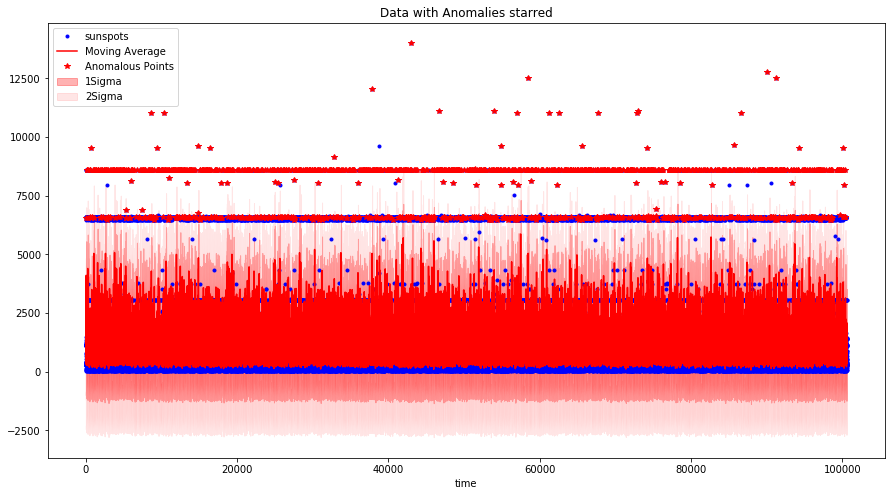

In [11]:
an.plot()

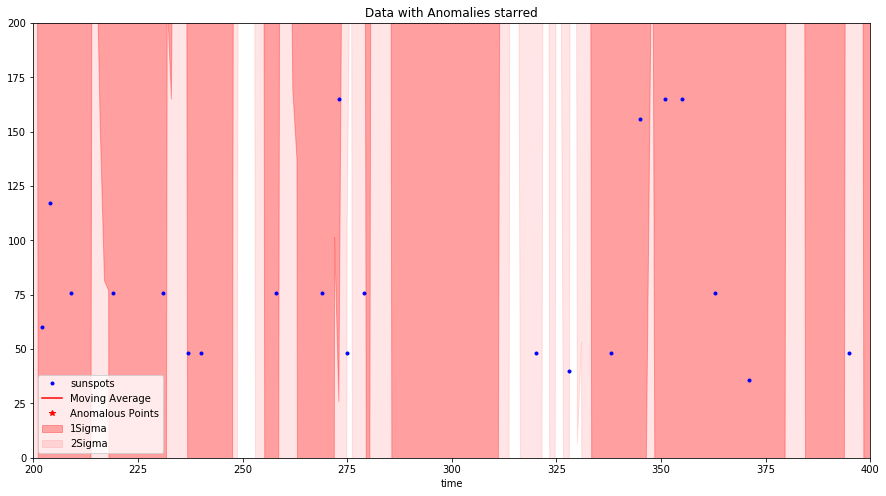

In [12]:
an.plot(left=200,right=400,top=200,bottom=0)

In [13]:
an.results.head()

,sunspots,mean_count,residual,pos_std,neg_std,pos_std_2,neg_std_2
time,,,,,,,
0,1120.0,1691.8,-571.8,3140.006033,243.593967,4588.212067,-1204.612067
1,6586.0,1715.2,4870.8,3163.406033,266.993967,4611.612067,-1181.212067
2,753.0,1939.2,-1186.2,3387.406033,490.993967,4835.612067,-957.212067
3,117.0,1782.4,-1665.4,3230.606033,334.193967,4678.812067,-1114.012067
4,1120.0,690.2,429.8,2138.406033,-758.006033,3586.612067,-2206.212067


In [14]:
an.anoma_points.head()

,sunspots
time,
62,6556.0
84,8609.0
116,8609.0
216,6556.0
324,8609.0
